In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
import pickle
from ase import Atoms
from ase.cluster import Cluster, Icosahedron
from ase import units as un
import ase.io
from IPython.core.display import Image
import numpy as np
from numpy import array, sum, std, mean
import scipy.interpolate as inter
import gzip

#  Warsztaty modelowania w nanofizyce
## Dynamika nanocząstek

<video style="margin:10px;" height=340 preload="metadata" type="video/webm"  autoplay loop 
    src="http://wolf.ifj.edu.pl/~jochym/p/notebooks/anim_T2000.webm" >
</video>

**Paweł T. Jochym**

Zakład Komputerowych Badań Materiałów

Instytut Fizyki Jądrowej PAN, Kraków

Prezentację można śledzić równolegle pod adresem: https://goo.gl/Nj8tah

Materiały pomocnicze do warsztatów mają formę zbioru zeszytów [Jupyter](https://jupyter.org/) dostępnych w publicznym repozytorium: https://goo.gl/5JKOJK

Kompletne środowisko do ćwiczeń wraz prezentacją i danymi znajduje się w serwisie binder (http://goo.gl/twpWel).

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/jochym/abinitio-workshop) 



## Plan

* Środowisko
* Schemat pracy
* Wyliczenie struktury nanocząstki
* Dynamika molekularna nanocząstki
* Termodynamika nanocząstki

## Środowisko pracy

Istnieje wiele sposobów organizacji pracy przy obliczeniowych badaniach materiałów. Kilka z nich można zobaczyć w pozostałych wykładach. Moja prezentacja posługuje się systemem Jupyter, który pozwala na mieszanie dokumentacji/notatek z kodem służącym do analizy danych, a także na przygotowanie materiału do prezentacji (jak np. slajdy które państwo widzą czy tekst artykułu).

Środowisko pracy składa się z następujących elementów:

 * System kolejkowy (wykonujacy zadania)

 * Serwer zarządzający (pozwalający zlecać zadania)

 * Serwer Jupyter (z nim łączymy się przeglądarką)

 * Terminal/klient (np. laptop z przeglądarką WWW)

**Uwaga:** *Tylko ostatnie dwa elementy dostępne są w paczce z serwisu binder - zawiera ona jedynie wyniki już przeprowadzonych obliczeń*

## Cykl życia publikacji w dziedzinie fizyki obliczeniowej
<img src="life-cycle_opt.svg" style="height:300px;" />

 * Nie ma wielkiej różnicy między badaniami eksperymentalnymi a teoretycznymi
 * Programy obliczeń z pierwszych zasad pełnią rolę aparatury eksperymentalnej
 * Cykl obliczeń, wizualizacji, interpretacji i modyfikacji obliczeń powtarza się wielokrotnie

 * Ważna jest dokumentacja etapów pracy
 * Dobrze gdy ostateczna publikacja budowana jest jednocześnie z produkcją wyników

## Cel badawczy

Naszym celem jest zbadanie zachowania warstwowych nanocząstek Fe-Pt w wysokich temperaturach. Mamy nadzieję wyznaczyć granicę stabilności termicznej takich nanocząstek.

<video height=450 preload="metadata" type="video/webm" autoplay controls
    src="http://wolf.ifj.edu.pl/~jochym/p/notebooks/anim_e.webm" >
</video>

## Struktura nanocząstki

Aby móc prowadzić rachunki musimy najpierw zdefiniować badaną strukturę. 
W naszym przypadku będzie to ikosaedryczna (dwudziestościenna) cząstka złożona z 55 atomów (1Pt+12Fe+42Pt).
Szczęśliwie, biblioteka którą się posługujemy (ASE - Atomistic Simulation Environment) zawiera funkcję 
budującą dwudziestościenne cząstki.

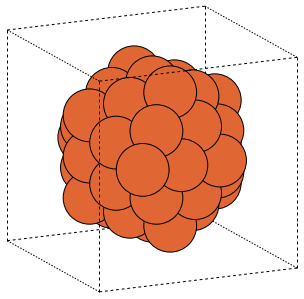

In [2]:
ico=Icosahedron("Fe", 3); ico.center(vacuum=2.0)
ase.io.write('fe-ico.png', ico, show_unit_cell=2, rotation='115y,15x', scale=20)
Image(filename='fe-ico.png')

## Struktura warstwowa 

*Cebula ma warstwy - Nanocząstki mają warstwy ... i nie są jak tort!*

Aby uzyskać zamierzoną strukturę warstwową wykorzystamy tę samą funkcję aby zidentyfikować kolejne warstwy cząstki i zdefiniować ich skład - na przemian Fe i Pt.

In [3]:
def LC_ico(a1,a2,ln):
    '''
    Stwórz strukturę warstwową rzędu ln 
    o naprzemiennych warstwach atomów a1, a2
    '''
    ico=Icosahedron(a1,ln)
    icon=ico.get_atomic_numbers()
    for l in range(ln,0,-1):
        if (ln-l)%2 :
            a=a1
        else :
            a=a2
        il=Icosahedron(a,l)
        an=il.get_atomic_numbers()
        icon[:len(an)]=an
    ico.set_atomic_numbers(icon)
    return ico      

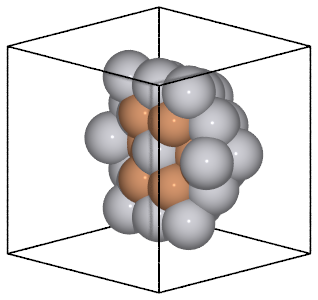

In [4]:
lc=LC_ico("Fe","Pt",3); lc.center(vacuum=2.0)
cut=lc.get_positions()[:,2].max()/2
ase.io.write('cebula.pov',
             lc[[a.index for a in lc if a.position[2]>=cut]], 
             show_unit_cell=2, rotation='135y,15x',
             canvas_height=300,run_povray=True)
Image(filename='cebula.png')

## Dynamika molekularna - co to jest?

**Dynamika molekularna** to badanie układów atomowych przez numeryczne rozwiązanie ich równania ruchu a następnie analizę tak uzyskanej trajektorii.

Równanie ruchu atomu o indeksie $i$:

$$
\frac{d^2{\mathbf x}_i}{{dt}^2}=\frac{{\mathbf F}_i}{m_i}
$$

rozwiązywane jest klasycznymi metodami numerycznego całkowania równan ruchu (np. algorytm *Verleta*), siły ${\mathbf F}_i$ pochodzą z rachunku *ab-initio* (siły *Hellmanna-Feynmana*).

Dla naszej struktury przeprowadzamy serię obliczeń w których nadajemy atomom różną średnią energię kinetyczną - czyli temperaturę: 

$$
T=\frac{2\langle E_k \rangle}{3k_B}.
$$

W rezultacie otrzymujemy trajektorie układu, które poddajemy dalszej analizie. 

## Obliczenia ab initio

*Ja, żeby nie tracić czasu, przygotowałem już sobie wcześniej ...*
(Adam Słodowy)

Obliczenia *ab-initio* użyte tutaj trwały długie miesiące. Samo ich przygotowanie i przeprowadzenie jest zabiegiem technicznym i nie jest szczególnie kształcące. Potrzebne wyniki tych obliczeń - w postaci kolekcji trajektorii - znajdują się w kartotece `data` w materiałach do ćwiczeń. Z konieczności, techniczne detale analizy pominięte są w prezentacji ale dostępne w jej pliku źródłowym oraz materiałach do ćwiczeń.

In [5]:
# Wczytanie danych wyliczonych przez program VASP przygotowanych wczesniej
md={}
for k,tr in pickle.load(gzip.open('data/md_PtFePt.p.gz','rb')).items():
    T=int(k.split('/')[-1][1:])
    md[T]=tr
    
print(sorted(md.keys()))

[150, 300, 500, 600, 700, 800, 850, 900, 950, 1000, 1100, 1200, 1300, 1350, 1400, 1425, 1450, 1500, 1600, 1700, 2000]


## Analiza trajektorii
W materiałach ćwiczeniowych znajduje się  kilka dalszych przykładów analizy uzyskanych trajektorii. Tutaj zajmiemy się uzyskaniem wykresu kalorymetrycznego ($E_p - E_k$ jako funkcja temperatury $T$), który pozwoli nam rozpoznać temperaturę topnienia nanocząstki o platynowej powierzchni. 
* Enargia potencjalna wyliczana jest przez program *ab-initio* i zawarta jest we wczytanych danych
* Energię kinetyczną musimy wyliczyć na podstawie trajektorii

$$
E_k(t_i)=\sum_{n=1}^{N_{at}}\frac{m_n {\mathbf v_n}(t_{i})^2}{2}=\sum_{n=1}^{N_{at}}\frac{m_n ({\mathbf x_n}(t_{i+1})-{\mathbf x_n}(t_{i}))^2}{2}
$$

### Realizacja obliczeń

In [6]:
def calc_velocities(a1,a2,dt):
    '''
    Wyliczenie prędkości atomów na podstawie pozycji a1, a2
    oraz odstępu czasu dt
    '''
    dx=(a2.get_positions()-a1.get_positions())
    c=Atoms(a2)
    tv=sum(c.get_cell(),axis=0)/2
    c.set_positions(dx)
    c.translate(tv)
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate(-tv)
    return c.get_positions()/dt

In [7]:
def calc_kinen(tr,dt):
    '''
    Wyliczenie energii kinetycznej atomów w trajektorii tr 
    przy kroku czasowym dt.
    '''
    m=tr[0].get_masses()
    Ek=[m*sum(calc_velocities(a1,a2,dt)**2,axis=1)/2 
                    for a1,a2 in zip(tr[:-1],tr[1:])]
    return Ek
    
def calc_temp(tr,dt):
    '''
    Wyliczenie chwilowej temperatury w trajektorii tr
    przy kroku czasowym dt
    '''
    eka=calc_kinen(tr,dt)
    ek=sum(eka,axis=-1)
    ekd=std(eka,axis=-1)
    n=len(tr[0].get_masses())
    c=n/(n-1)
    return 2*c*ek/(3*n*un.kB), 2*c*ekd/(3*un.kB)

### Fluktuacje energii kinetycznej

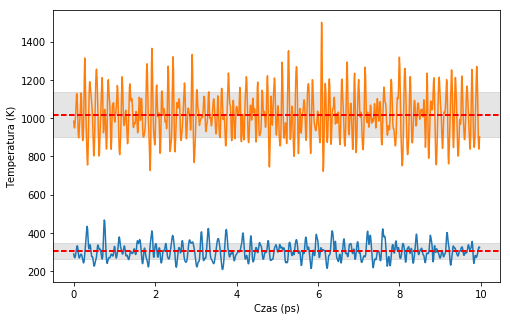

In [21]:
plt.figure(figsize=(8,5))
for T in [300, 1000]:
    dt,tr=md[T]; temp,_=calc_temp(tr,dt*un.fs)
    avgT=mean(temp) ; devT=std(temp)
    plt.plot(dt*np.arange(len(temp))/1000,temp,'-')
    plt.axhline(avgT,ls='--',color='r',lw=2)
    plt.axhspan(avgT-devT,avgT+devT,color='C7',alpha=0.2)
plt.xlabel('Czas (ps)'); plt.ylabel('Temperatura (K)');

### Krzywa kalorymetryczna

Wyliczamy:
 * Energię potencjalną (zapisana w rezultatach obliczeń *ab-initio*)
 * Energię kinetyczną
 * Średnią temperaturę

In [22]:
dat=[]
for T in sorted(md):
    dt,tr=md[T]
    epot=array([s.get_potential_energy() for s in tr])
    epot=((epot[:-1]+epot[1:])/2)
    ekin=sum(array(calc_kinen(tr,dt*un.fs)),axis=-1)
    etot=epot+sum(ekin,axis=-1)
    temp_v, temp_d=calc_temp(tr,dt*un.fs)
    atemp=mean(temp_v)
    dat.append([atemp, mean(epot), mean(ekin),
                mean((etot-mean(etot))**2)/(un.kB*(atemp**2))])
dat=array(dat).T

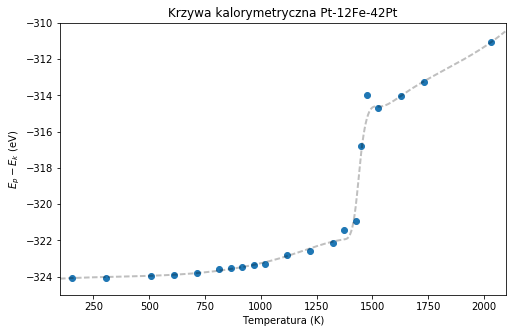

In [24]:
plt.figure(figsize=(8,5))
plt.plot(dat[0],dat[1]-dat[2],'o')
x=(dat[0])[np.arange(dat.shape[1])!=16]; 
y=(dat[1]-dat[2])[np.arange(dat.shape[1])!=16]
s=inter.UnivariateSpline(x, y, s=1.3)
xx=np.arange(100,2100,5)
plt.plot(xx,s(xx),'k--',lw=2,alpha=0.25);
plt.xlabel('Temperatura (K)'); plt.ylabel('$E_p - E_k$ (eV)');
plt.title('Krzywa kalorymetryczna Pt-12Fe-42Pt')
plt.xlim(100,2100); plt.ylim(-325,-310); 

## Podsumowanie

* Obliczenia z pierwszych zasad rzadko dostarczają bezpośrednio mierzalnych wielkości fizycznych.
* Analiza i dalsze przetwarzanie danych uzyskanych metodami obliczeniowej mechaniki kwantowej są tak samo ważne jak same obliczenia z pierwszych zasad.
* Wygodne środowisko i bogata biblioteka funkcji może znacząco usprawnić proces analizy uzyskanych wyników.

* Należy pamiętać że komputery pracują w systemie:

    **Ś-Ś** **(Śmieci na wejściu - Śmieci na wyjściu)** 


* Chwila zastanowienia jest niejednokrotnie więcej warta niż miesiące obliczeń

*Wszystkie obliczenia prowadzące do pokazanych wyników, oraz wszystkie konieczne dane są dostępne w plikach źródłowych oraz materiałach ćwiczeniowych. Wszystkie materiały można znaleźć pod adresem: https://goo.gl/5JKOJK *

## Dziękuję za uwagę!
---
### *Zapraszam na ćwiczenia praktyczne!*